翻译自：Machine Learning for Finance（第四章）
![book](./img/ml_finance.jpg)
链接：https://book.douban.com/subject/30220489/

时间序列是一种具有时间维度的数据形式，最具标志性的就是金融数据。虽然单个股票报价不是时间序列，但将您通过将每天获得的报价拿来并排列它们，就会得到更有趣的时间序列。几乎所有与金融有关的媒体材料迟早都会报道股价差距，而不是给定时刻的价格清单，而是随着时间的推移价格的发展。
您经常会听到财务评论员讨论价格走势：“Apple Inc.上涨5％。” 但是，这是什么意思？您所听到的绝对价值要少得多，例如，“Apple Inc.的股价为137.74美元。” 同样，这是什么意思？之所以会这样，是因为市场参与者对未来的发展趋势很感兴趣，并且他们试图从过去的发展趋势中推断出这些未来的预测。
![1.1](./img/1.1.png)

大多数预测都涉及查看一段时间内的过去发展情况。时间序列数据集的概念是与预测相关的重要元素。例如，农民在预测农作物产量时将查看时间序列数据集。因此，在统计，计量经济学和工程学领域中已经开发出了大量与时间序列相关的知识和工具。

在本章中，我们将研究一些今天仍然非常相关的经典工具。然后，我们将学习神经网络如何处理时间序列，以及深度学习模型如何表达不确定性。

在我们着眼于时间序列之前，我需要设定您对本章的期望。你们中许多人可能已经读过本章，以了解有关股票市场的预测，但是我需要警告您，本章与股票市场的预测无关，其他章节也不会涉及。
经济理论表明，市场有些有效。有效市场假说指出，所有公开可用的信息都包含在股票价格中。这扩展到有关如何处理信息的信息，例如“预测算法”。

如果这本书提出一种可以预测股市价格并带来丰厚回报的算法，那么许多投资者只会简单地实现该算法。由于这些算法都会在预期价格变化的情况下进行买卖，因此它们会改变当前的价格，从而破坏了使用该算法将获得的优势。因此，提出的算法不适用于将来的读者。

相反，本章将使用维基百科的流量数据。我们的目标是预测特定Wikipedia页面的访问量。我们可以通过Wikipediatrend CRAN包获取Wikipedia流量数据。

我们在这里使用的数据集是Google提供的大约145,000个Wikipedia页面的流量数据。数据可以从Kaggle获得。

数据可以从以下位置获取：

- https://www.kaggle.com/c/web-traffic-time-series-forecasting

- https://www.kaggle.com/muonneutrino/wikipedia-traffic-data-exploratio

# [pandas的可视化与准备工作](#content)

在开始训练之前获得数据整体概述通常是一个好主意。针对我们从Kaggle获得的数据，您可以通过运行以下操作实现此目标：

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.fftpack import fft

In [4]:
train = pd.read_csv("./data/train_1.csv").fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


页面列中的数据包含页面名称，维基百科页面的语言，访问设备的类型和访问代理。
其他列包含该日期与该页面的点击量。

因此，在上表中，第一行包含通过所有访问方式在中文版的Wikipedia上朝鲜流行乐队2NE1的页面，但仅适用于被归类为爬虫代理商的数据。也就是说，流量是通过爬虫访问的数据量。尽管大多数时间序列工作都集中在与时间相关的局部特征上，但我们可以通过提供对全局特征的访问来丰富所有模型。
因此，我们希望将页面字符串拆分为更小，更有用的功能。我们可以通过运行以下代码来实现此目的：

In [5]:
def parse_page(page):
    x = page.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]

我们用下划线将字符串分开。页面名称中还可以包含下划线，因此我们将最后三个字段分开，然后将其余字段合并在一起以获取本文的主题。
如下面的代码所示，倒数第二个元素是子URL，例如，en.wikipedia.org。倒数第二个元素是访问权限，最后一个元素是代理：

In [6]:
parse_page(train.Page[0])

('2NE1', 'zh.wikipedia.org', 'all-access', 'spider')

当我们将此功能应用于训练集中的每个页面条目时，我们将获得一个元组列表，然后我们可以将其合并到一个新的DataFrame中，如下面的代码所示：

In [7]:
l = list(train.Page.apply(parse_page))
df = pd.DataFrame(l)
df.columns = ['Subject','Sub_Page','Access','Agent']

最后，我们必须在删除原始页面列之前将此新的DataFrame添加回我们的原始DataFrame中，我们可以通过运行以下操作来做到这一点：

In [8]:
train = pd.concat([train, df], axis = 1)
del train['Page']

In [9]:
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Subject,Sub_Page,Access,Agent
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh.wikipedia.org,all-access,spider
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh.wikipedia.org,all-access,spider
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh.wikipedia.org,all-access,spider
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh.wikipedia.org,all-access,spider
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,11.0,27.0,13.0,36.0,10.0,52 Hz I Love You,zh.wikipedia.org,all-access,spider


运行此代码的结果是，我们成功完成了数据集的加载。这意味着我们现在可以继续探索它。

## [汇总全局特征统计](#content)

经过所有这些艰苦的工作，我们现在可以创建一些有关全局特征的汇总统计信息。

使用pandas value_counts()函数可以轻松绘制全局特征的分布图。通过运行以下代码，我们将获得Wikipedia数据集的条形图输出：

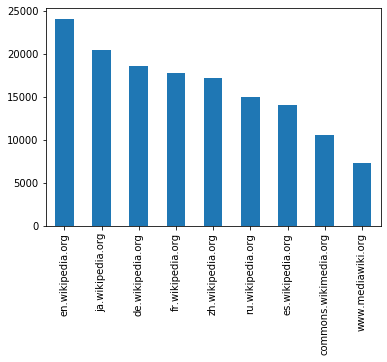

In [10]:
train.Sub_Page.value_counts().plot(kind='bar')
plt.show()

维基百科具有不同语言的子页面，我们可以看到我们的数据集包含来自英语（en），日语（ja），德语（de），法语（fr），中文（zh），俄语（ru）和西班牙语的页面 （es）维基百科站点。

在我们制作的条形图中，您可能还注意到了两个基于非国家/地区的Wikipedia网站。
commons.wikimedia.org 和 www.mediawiki.org 都用于托管媒体文件，例如图像。

让我们再次运行该命令，这次重点关注访问类型：

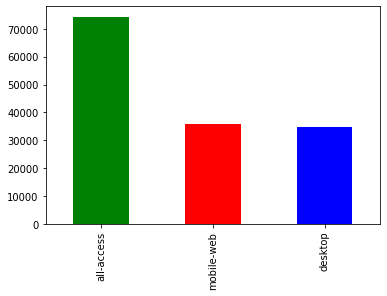

In [11]:
train.Access.value_counts().plot(kind='bar', color={"r", "g", "b"})
plt.show()

有两种可能的访问方法：移动和桌面。还有第三个选项全访问，它结合了移动和桌面访问的统计信息。

然后，我们可以通过运行以下代码来按代理绘制记录的分布图：

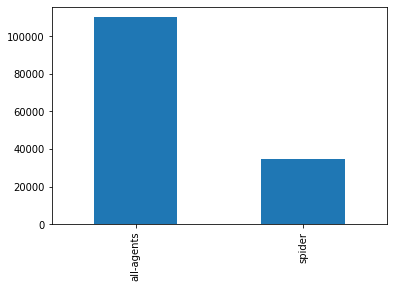

In [12]:
train.Agent.value_counts().plot(kind='bar')
plt.show()

时间序列不仅适用于爬虫，而且适用于所有其他类型的访问。在经典统计建模中，下一步将是分析每个全局特征的影响并围绕它们构建模型。但是，如果有足够的数据和计算能力可用，这不是必需的。

神经网络能够发现全局特征本身的影响，并根据它们之间的相互作用来创建新特征。对于全局功能，只有两个实际的考虑需要解决：

- 特征分布是否偏斜？如果是这种情况，那么可能只有少数具有全局特征的实例，我们的模型可能会过度适合于该全局特征。想象一下，在数据集中只有很少的中文维基百科的“文章”。该算法可能会基于特征区分太多，然后过度拟合了少数中文条目。我们的分布相对均匀，因此我们不必为此担心。

- 可以轻松编码特征吗？某些全局功能不能一键编码。想象一下，我们获得了带有时间序列的Wikipedia文章的全文。不能立即使用此功能，因为必须进行一些繁重的预处理才能使用它。在我们的案例中，有一些相对简单的类别可以进行一键编码。但是，主题名称不能一键编码，因为主题名称过多。

## [检查样本时间序列](#content)

要检查数据集的全局特征，我们必须查看一些示例时间序列，以了解我们可能面临的挑战。在本部分中，我们将为美国音乐人Twenty One Pilot的英语语言页面绘制视图。

绘制实际的网页浏览量以及10天的滑动平均值。我们可以通过运行以下代码来做到这一点：

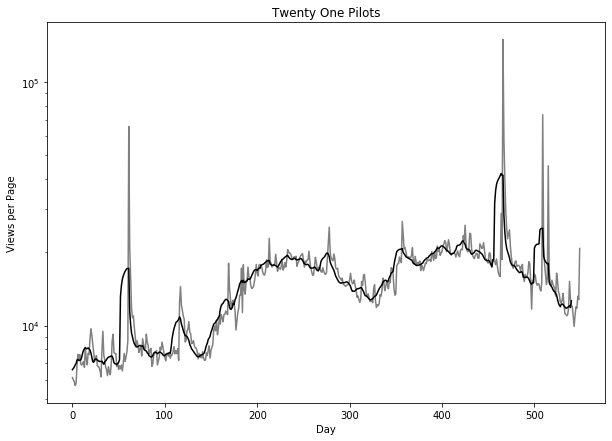

In [13]:
idx = 39457
window = 10
data = train.iloc[idx,0:-4]
name = train.iloc[idx, -4]
days = [r for r in range(data.shape[0])]
fig, ax = plt.subplots(figsize=(10,7))
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title(name)

ax.plot(days,data.values,color='grey')
ax.plot(np.convolve(data, 
                    np.ones((window,))/window, 
                    mode='valid'),color='black')
ax.set_yscale('log')

此代码段中正在进行很多工作，值得逐步进行分析。首先，我们定义要绘制的行。Twenty One Pilots是训练数据集中的第39,457行。之后我们定义了华东平均值的窗口大小。

我们使用pandas iloc工具将页面视图数据和名称与整体数据集分开。这使我们可以按行和列坐标索引数据。计算天数而不是显示所有测量日期将使该图更易于阅读，因此我们将为X轴创建一个天数计数器。

接下来，我们设置图并通过设置figsize确保其具有所需的大小。我们还定义了轴标签和标题。接下来，我们绘制实际的页面浏览量。我们的X坐标是天，Y坐标是页面浏览量。

为了计算均值，我们将使用卷积运算。此卷积操作将创建一个矢量除以窗口大小（在本例中为10）的矢量。卷积操作将矢量在页面视图上滑动，将10页视图与1/10相乘，然后将所得的矢量求和。这将创建一个华东平均值，其窗口大小为10。我们将该平均值绘制为黑色。最后，我们指定要对Y轴使用对数刻度。

您可以看到，即使我们使用了对数轴，在我们刚刚生成的Twenty One Pilots图中也会出现一些相当大的峰值。在某些日子里，观看次数猛增到几天前的10倍。因此，很快就很清楚，一个好的模型必须能够应对这种极端的问题。

在我们继续之前，值得指出的是，随着页面浏览量通常随着时间的增加，全球趋势也很明显。

从好的方面来说，让我们对所有语言的Twenty One Pilots页面浏览进行绘制。我们可以通过运行以下代码来做到这一点：

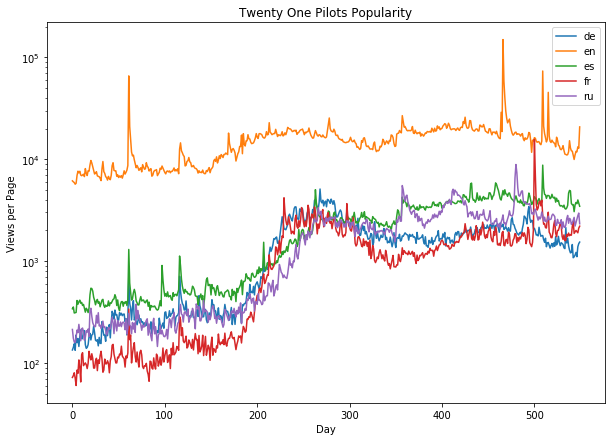

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Twenty One Pilots Popularity')
ax.set_yscale('log')

for country in ['de','en','es','fr','ru']:
    idx= np.where((train['Subject'] == 'Twenty One Pilots') 
                  & (train['Sub_Page'] == '{}.wikipedia.org'.format(country)) & (train['Access'] == 'all-access') & (train['Agent'] == 'all-agents'))
                  
    idx=idx[0][0]
    
    data = train.iloc[idx,0:-4]
    handle = ax.plot(days,data.values,label=country)
    

ax.legend()

在此代码中，我们像以前一样先设置图表。然后，我们遍历语言代码，找到Twenty One Pilots的索引。索引是包装在元组中的数组，因此我们必须提取指定实际索引的整数。然后，我们从训练数据集中提取页面浏览量数据并绘制页面浏览量。

时间序列之间显然存在一些相关性。毫不奇怪，到目前为止，英语版本的Wikipedia（第一行）最受欢迎。我们还可以看到数据集中的时间序列显然不是固定的; 随着时间的推移它们会改变均值和标准偏差。

平稳过程是指其无条件联合概率分布随时间保持不变的过程。换句话说，诸如系列平均值或标准偏差之类的东西应该保持不变。

但是，正如您所看到的，在上图中的200-250天之间，页面上的平均观看次数发生了巨大变化。此结果破坏了许多经典建模方法所做的某些假设。但是，金融时间序列几乎从未停止过，因此值得解决这些问题。通过解决这些问题，我们熟悉了可以帮助我们处理非平稳性的几种有用工具。

# [不同种类的平稳性](#content)

平稳性可能意味着不同的事情，因此了解手头任务需要哪种平稳性至关重要。为简单起见，在这里我们仅讨论两种平稳性：平均平稳性和方差平稳性。下图显示了四个具有不同程度（非平稳）平稳性的时间序列：

![1.2](./img/1.2.png)

平均平稳性是指一系列水平是恒定的。当然，这里的单个数据点可能会偏离，但长期平均值应该是稳定的。

方差平稳性是指与均值不变的方差。同样，可能存在离群值和短序列，其方差似乎更高，但总体方差应处于同一水平。

第三种平稳性很难直观显示，此处未显示，它是“协方差平稳性。这是指不同滞后之间的协方差是恒定的。人们提到协方差平稳性时，通常是指均值，方差和协方差是固定的特殊条件。许多计量经济学模型（尤其是风险管理模型）都在这种协方差平稳性假设下运行。

## [为什么平稳性很重要](#content)

许多经典的计量经济学方法都采用某种形式的平稳性。这样做的一个关键原因是，在时间序列固定的情况下，推理和假设检验的效果更好。但是，即使从纯粹的预测角度来看，平稳性也会有所帮助，因为它会使我们的模型失去一些工作。看一下前面图表中的“不平稳”系列。您可以看到预测该系列的主要部分是要认识到该系列向上移动的事实。如果我们可以在模型之外捕捉到这一事实，则该模型必须学习更少，并且可以将其功能用于其他目的。另一个原因是，它将我们输入模型的值保持在相同范围内。请记住，在使用神经网络之前，我们需要对数据进行标准化。如果股价从1美元涨到1,000美元，我们最终将获得非标准化的数据，这反过来将使培训变得困难。

## [使时间序列保持平稳](#content)

在金融数据（尤其是价格）中实现平均平稳性的标准方法称为差异。它是指计算价格收益。在下面的图像中，您可以看到S&P 500的原始版本和差异版本。原始版本并不是随着价值的增长而固定不变，而差异版本几乎是固定的。

![1.3](./img/1.3.png)

平均平稳性的另一种方法是基于线性回归。在这里，我们将线性模型拟合到数据。statsmodels是此类经典建模的一个流行库，它具有内置的线性回归模型。下面的示例说明如何使用statsmodels从数据中删除线性趋势：

In [15]:
time = np.linspace(0,10,1000)
series = time
series = series + np.random.rand(1000) * 0.2
mdl = sm.OLS(time, series).fit()
trend = mdl.predict(time)

In [16]:
trend

array([0.        , 0.00985241, 0.01970482, 0.02955723, 0.03940964,
       0.04926205, 0.05911446, 0.06896687, 0.07881928, 0.08867169,
       0.0985241 , 0.10837651, 0.11822892, 0.12808133, 0.13793374,
       0.14778615, 0.15763856, 0.16749097, 0.17734338, 0.18719579,
       0.1970482 , 0.20690061, 0.21675301, 0.22660542, 0.23645783,
       0.24631024, 0.25616265, 0.26601506, 0.27586747, 0.28571988,
       0.29557229, 0.3054247 , 0.31527711, 0.32512952, 0.33498193,
       0.34483434, 0.35468675, 0.36453916, 0.37439157, 0.38424398,
       0.39409639, 0.4039488 , 0.41380121, 0.42365362, 0.43350603,
       0.44335844, 0.45321085, 0.46306326, 0.47291567, 0.48276808,
       0.49262049, 0.5024729 , 0.51232531, 0.52217772, 0.53203013,
       0.54188254, 0.55173495, 0.56158736, 0.57143977, 0.58129218,
       0.59114459, 0.600997  , 0.61084941, 0.62070182, 0.63055422,
       0.64040663, 0.65025904, 0.66011145, 0.66996386, 0.67981627,
       0.68966868, 0.69952109, 0.7093735 , 0.71922591, 0.72907

![1.4](./img/1.4.png)
值得强调的是，平稳性是建模的一部分，应该只适用于训练集。差分不是一个大问题，但可能导致线性去趋势问题。

消除方差非平稳性更加困难。一种典型的方法是计算一些滚动方差，然后将新值除以该方差。在训练集上，您还可以对数据进行学习。为此，您需要计算每日方差，然后将所有值除以其根。同样，您只能对训练集执行此操作，因为方差计算需要您已经知道值。

## [何时忽略平稳性问题](#content)

有时候您不应该担心平稳性。预测突然的变化时，例如所谓的结构性断裂。在Wikipedia示例中，我们有兴趣知道何时开始访问网站的频率比以前高得多。在这种情况下，消除水平差异会阻止我们的模型学习预测此类变化。同样，我们可能能够轻松地将非平稳性纳入我们的模型中，或者可以在pipline的后期阶段确保它。我们通常只在整个数据集的一小部分子序列上训练神经网络。如果我们对每个子序列进行标准化，则子序列内均值的移动可能会忽略不计，我们不必为此担心。预测比推理和假设测试要宽容得多，因此，如果我们的模型可以在这样的数据上进行预测，那么我们可能会摆脱一些不稳定的问题。

# [快速傅立叶变换](#content)

我们经常想计算的关于时间序列的另一个有趣的统计数据是傅立叶变换（FT）。无需进行数学运算，傅立叶变换将向我们显示函数中特定频率内的振荡量。

您可以像老式FM收音机上的调谐器那样想象。转动调谐器时，您会搜索不同的频率。每隔一段时间，您会发现一个频率，可为您清楚地显示特定广播电台的信号。傅立叶变换基本上扫描整个频谱，并记录在哪个频率上有强信号。就时间序列而言，这在尝试查找数据中的周期性模式时很有用。

想象一下，我们发现每周有一个频率会给我们一个强有力的模式。这意味着对一周前同一天的流量的了解将有助于我们的模型。

当函数和傅立叶变换都是离散的时（在一系列日常测量中就是这种情况），它称为离散傅立叶变换（DFT）。一种用于计算DFT的非常快速的算法称为快速傅立叶变换（FFT），今天它已成为科学计算中的重要算法。数学家卡尔·高斯（Carl Gauss）于1805年就知道了这一理论，但美国数学家詹姆斯·W·库利（James W. Cooley）和约翰·图基（John Tukey）于1965年才发现这一理论。

傅立叶变换的工作方式和原因超出了本章的范围，因此在本节中，我们仅作简要介绍。想象一下我们作为电线的功能。我们将这根导线缠绕并缠绕在一个点上，如果缠绕该导线以使该点周围的转数与信号的频率匹配，则所有信号峰值将位于极点的一侧。这意味着导线的质心将远离我们缠绕导线的位置。

在数学上，可以通过将函数g(n乘以 $e^{-2 \pi i f n}$ 来将函数环绕在点上，其中f是环绕的频率，n是序列中项的编号，i是虚数的平方根-1。不熟悉虚数的读者可以将它们视为坐标，其中每个数都有一个包含实数和虚数的二维坐标。

为了计算质心，我们对离散函数中的点坐标进行平均。因此，DFT公式如下：

$$
y[f]=\sum_{n=0}^{N-1} e^{-2 \pi i \frac{f n}{N}} x[n]
$$


这里y[f]是变换后的序列中的第f个元素，而x[n]是输入序列x中的第n个元素。N是输入序列中的总点数。请注意，y[f]将是一个包含实元素和离散元素的数字。

要检测频率，我们只对y[f]的整体幅度感兴趣。为了获得此大小，我们需要计算虚部和实部的平方和的根。在Python中，我们不必担心所有的数学运算，因为我们可以使用scikit-learn的fftpack，它内置了FFT函数。

下一步是运行以下代码：

In [18]:
data = train.iloc[:,0:-4]
fft_complex = fft(data)
fft_mag = [np.sqrt(np.real(x) * np.real(x) + np.imag(x) * np.imag(x)) for x in fft_complex]

在这里，我们首先从训练集中提取没有全局特征的时间序列测量值。然后我们运行FFT算法，最后算出变换幅度。

运行该代码后，我们现在对所有时间序列数据集进行了傅里叶变换。为了使我们能够更好地了解傅立叶变换的一般行为，我们可以通过简单地运行它们来对它们进行平均：

In [19]:
arr = np.array(fft_mag)
fft_mean = np.mean(arr, axis=0)

这首先将幅度转换为NumPy数组，然后计算平均值。我们要计算每个频率的平均值，而不仅仅是所有幅度的平均值，因此我们需要指定获取平均值的轴。

在这种情况下，序列数据是按行堆叠的，因此采用列平均（轴零）将导致频率均值。为了更好地绘制变换图，我们需要创建一个测试频率列表。频率的格式为：每天数据集中的天/全天，因此1 / 550、2 / 550、3 / 550等。要创建列表，我们需要运行：

In [20]:
fft_xvals = [day / fft_mean.shape[0] for day in range(fft_mean.shape[0])]

在此可视化中，我们只关心每周范围内的频率范围，因此我们将删除转换的后半部分，我们可以通过运行以下操作来做到这一点：

In [21]:
npts = len(fft_xvals) // 2 + 1
fft_mean = fft_mean[:npts]
fft_xvals = fft_xvals[:npts]

最后，我们可以绘制变形图：

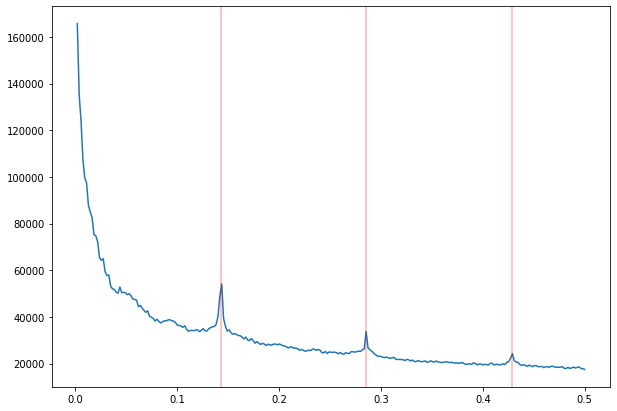

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fft_xvals[1:],fft_mean[1:])
plt.axvline(x=1./7,color='red',alpha=0.3)
plt.axvline(x=2./7,color='red',alpha=0.3)
plt.axvline(x=3./7,color='red',alpha=0.3)
plt.show()

正如您在我们生成的图表中所看到的那样，峰值大约为1/7（0.14），2/7（0.28）和3/7（0.42）。由于一周有7天，因此，频率为每周一次，每周两次和每周3次。换句话说，页面统计信息每周（大约）重复一次，因此，例如，一个星期六的访问量与上一个星期六的访问量相关。

# [自相关](#content)

自相关是由给定间隔分隔的序列中两个元素之间的相关性。直观地，例如，我们假设有关上一步的知识有助于我们预测下一步。但是从两个时间步长之前或从100个时间步长之前的知识怎么样？

运行autocorrelation_plot将绘制具有不同滞后时间的元素之间的相关性，并可以帮助我们回答这些问题。事实上，pandas附带了一个方便的自相关绘图工具。要使用它，我们必须传递一系列数据。在我们的例子中，我们传递了随机选择的页面浏览量。

我们可以通过运行以下代码来做到这一点：